# Manifolds

In [1]:
%load_ext autoreload
%autoreload 2
import latenta as la
import lacell as lac
import numpy as np

We'll use the same dataset as [before](./1-variables)

In [2]:
adata = la.data.load_myod1()

In [3]:
import scanpy as sc

adata.raw = adata

sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

sc.pp.combat(adata)
sc.pp.pca(adata)

sc.pp.neighbors(adata)
sc.tl.umap(adata)

adata.obs["log_overexpression"] = np.log1p(adata.obs["overexpression"])

/home/wsaelens/projects/probabilistic-cell/.venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'dissociation' as categorical


/home/wsaelens/projects/probabilistic-cell/.venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'gene_overexpressed' as categorical


/home/wsaelens/projects/probabilistic-cell/.venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'batch' as categorical


/home/wsaelens/projects/probabilistic-cell/.venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'biotype' as categorical


/home/wsaelens/projects/probabilistic-cell/.venv/lib/python3.8/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


So far, we have focused on models that basically look like this:

![](_static/previous.svg)

We have a transcriptome that we want to explain using some model, and this model contains latent variables that are specific to genes (for example the fold change), and known variables that are specific to the cells (for example the overexpression of *Myod1*).

But what if our cellular variables are also unknown, i.e. latent?

![](_static/now.svg)

In this case, apart from learning a latent space about genes, we _at the same time_ also try to learn a latent space on cells, also known as the "cellular manifold". There are many different ways to represent this manifold, and how to do this depends on what we know about the cells and what we try to accomplish:

- **embedding**: Each cell is placed in an n-dimensional space, with only a few restrictions, such as the cell positions are all centered around 0. This space is very flexible, but not interpretable. Essentially, it is only interpretable when converted to a 2D representation and viewed by the human eye. Related to this, this space is typically far removed from biological reality. A cell's state does not "float" in an n-dimensional space.
- **scalar** (differentiation, cell cycle, ...): Each cell is placed in a one-dimensional space, with a single pseudotime.

While many manifold models are relatively easy to implement, the main difficulty lies in the interpretability. Especially when different **cellular processes** are happening at the same time in a cell, a single latent variable will typically try to explain all of them. What is therefore often required is the inclusion of prior knowledge that can help with disentangling different cellular processes.

To disentangle cellular processes in a dataset, we typically go through 3 phases:

1. We first model what we already know is present in the data, e.g. batch effects, overexpression, ...
2. We then model what we think is likely (based on what we know) and to which we can include some prior knowledge, e.g. cell cycle, differentiation ... You should see prior knowledge very broadly, as it not only contains your own knowledge but also information from your own control datasets, other databases, cell atlas projects ...
3. Finally, we try to model what is fairly hypothetical, e.g. new substates, different differentiation paths, interactions between processes ...

It's important to understand that this way of working is no different than classical biological research (or any research for that matter). The only difference is that we're working with large datasets and/or complex designs, which require us to put this within a fully computational probabilistic framework.


## Differentiation: Inferring a dominant scalar latent variable

Let's explore what heterogeneity might be present in our cells. Let's first extract the cell cycle phases using the (current) canonical approach:

In [4]:
cellcycle_genes = lac.transcriptome.effects.cellcycle.get_cellcycle_genes()
sc.tl.score_genes_cell_cycle(
    adata,
    s_genes=cellcycle_genes.query("phase == 'S'")["gene"].tolist(),
    g2m_genes=cellcycle_genes.query("phase == 'G2/M'")["gene"].tolist(),
)

Let's also look at the expression of some myogenesis and cell cycle genes within a two-dimensional representation:

/home/wsaelens/projects/probabilistic-cell/.venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'phase' as categorical


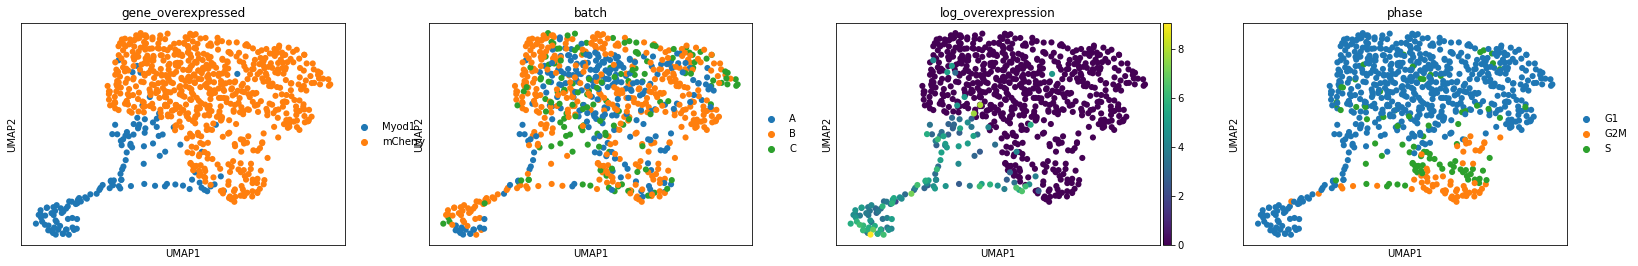

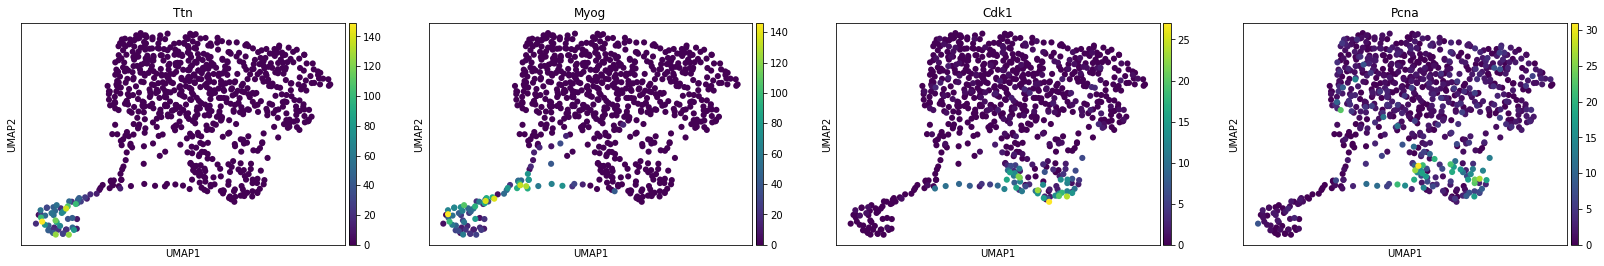

In [5]:
symbols = ["Ttn", "Myog", "Cdk1", "Pcna"]
sc.pl.umap(adata, color=["gene_overexpressed", "batch", "log_overexpression", "phase"])
sc.pl.umap(
    adata, color=adata.var.set_index("symbol").loc[symbols]["ens_id"], title=symbols
)

Just by looking at this 2D representation, it's immediately obvious that there are two dominant processes going on in the cell: differentiation (in this case to myocytes) and the cell cycle. On top of that, it seems that there is some heterogeneity in the control cells (*mCherry* cells), although the magnitude of this is difficult to determine based on a 2D representation.

Although in a typical use case we would model the cell cycle first, for illustrative purposes we will first look at the differentiation. We can "remove" (or reduce) the effect of the cell cycle by removing the cycling cells.

In [6]:
adata_oi = adata[adata.obs["phase"] == "G1"].copy()

In [7]:
transcriptome = lac.transcriptome.TranscriptomeObservation.from_adata(adata_oi)

We define the differentiation as a _scalar_ latent variable, that assigns to each cell one value. This single value in our case is again modelled as a latent variable, with both a prior and variational distribution, the latter capturing it uncertainty.

Crucial here is that we provide an appropriate prior distribution. Given that we assume that differentiation has a start and an end, we want to place the cells somewhere in the  $[0, 1]$ interval. We do not have any specific nowledge if the Myod1 cells are more concentrated at early or late differentiation stage, so we would like to set a prior saying that every time along the differentiation process is equally likely. A uniform distribution is therefore most appropriate. Do note that other cellular processes may have other assumptions or hypotheses, and will therefore require different priors as we will see later.

In [8]:
differentiation = la.Latent(
    la.distributions.Uniform(),
    definition=[transcriptome["cell"]],
    label="differentiation",
)
differentiation

differentiation: q, p ↦ Latent [cell (•)] ~ Uniform

Now that we have defined the cellular latent space, we still have to define how this space affects the transcriptome. Given that we (can) assume that _most_ genes will change smoothly but non-linearly during differentiation, we choose a spline function for this:

In [9]:
foldchange = transcriptome.find("foldchange")
foldchange.differentiation = la.links.scalar.Spline(
    differentiation, definition=foldchange.value_definition
)
foldchange.plot()

:::{note}

Although a spline function is flexible, like always we do still make some assumptions, namely:
- The outcome is smooth, without a lot of sudden jumps.
- The flexibility is limited by the number of knots. There is a trade-off here, as more knots will mean more flexibility but also more chances of overfitting.

:::

As before, we also want to correct for the batch effect (again remember that the foldchange is an additive modular variable, so we can add any components we want and the foldchange will be a linear combination of them):

In [10]:
batch = la.variables.discrete.DiscreteFixed(adata_oi.obs["batch"])
foldchange.batch = la.links.vector.Matmul(batch, definition=foldchange.value_definition)

In [11]:
foldchange.plot()

In [12]:
with transcriptome.switch(la.config.device):
    inference = la.infer.svi.SVI(
        transcriptome, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.05)
    )
    trainer = la.infer.trainer.Trainer(inference)
    trace = trainer.train(10000)
    trace.plot()

  0%|                                                                                                         …

We can extract the inferred values using a `~latenta.posterior.scalar.ScalarObserved` posterior:

In [13]:
differentiation_observed = la.posterior.scalar.ScalarObserved(differentiation)
differentiation_observed.sample(10)

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot:xlabel='differentiation', ylabel='Count'>

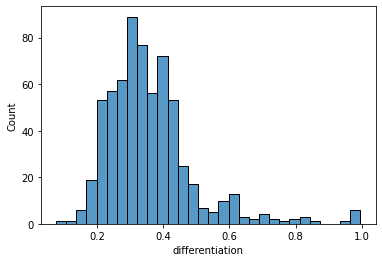

In [14]:
differentiation_observed.plot()

In [15]:
adata_oi.obs["differentiation"] = differentiation_observed.mean.to_pandas()

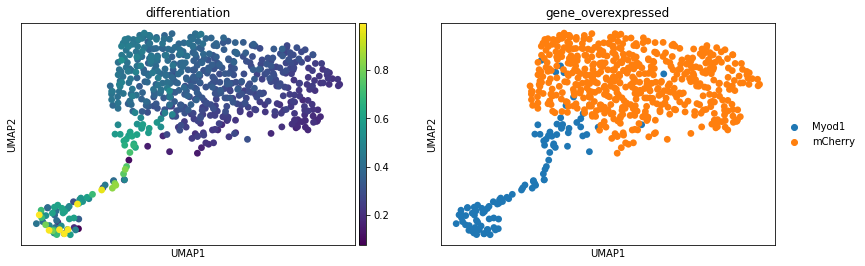

In [16]:
sc.pl.umap(adata_oi, color=["differentiation", "gene_overexpressed"])

This may look good at first sight, but not if we take a closer look. After all, about half of the differentiation is used up by cells coming from the control cells!

## Differentiation: Providing a little bit of prior knowledge

In this case, we can easily fix this by including some external information. Namely, we know which cells were not perturbed, and we can therefore _nudge_ the differentiation values of those cells close to 0 by specifying an appropriate prior distribution.

Before we specified the prior $p$ of the differentiation to be a uniform distribution as we argued that we do not know if our cells are more concentrated at any time point in the differentation process. However, this prior is for now set for all the cells (controls or overexpressing *Myod1*) meaning that all the cells are as likely to contribute to any time of the differentiation process. But this is not true, we know that our control cells are concentrated at the very beggining of the differentiation process as they are undifferentiated. We therefore wants a prior which as the same time is more or less uniform for the *Myod1* cells but close to 0 everywhere except at the very begining for the control cells.

In [17]:
transcriptome = lac.transcriptome.TranscriptomeObservation.from_adata(adata_oi)

In [18]:
# gene_overexpressed = la.variables.DiscreteFixed(adata_oi.obs["gene_overexpressed"])

In [19]:
# alpha_go = la.Fixed(pd.Series([1., 1.], index = adata_oi.obs["gene_overexpressed"].cat.categories), label = "alpha")
# beta_go = la.Fixed(pd.Series([1., 100.], index = adata_oi.obs["gene_overexpressed"].cat.categories), label = "beta")

This nudging is performed by an appropriate prior distribution. A beta distribution becomes very handy here, indeed depending on the parameters it can either be a uniform  distribution or can be concentrated at any value we want! So we will now set the prior of the differentiation as a beta distribution for which its two parameters alpha and beta will depend on if it's a control of *Myod1* overexpressing cell.

Note that a $\beta$(1,1) is a uniform, and a $\beta$(1,100) is very concentrated at 0.

In [20]:
import pandas as pd

differentiation_p = la.distributions.Beta(
    beta=la.Fixed(
        pd.Series([1.0, 100.0], index=["Myod1", "mCherry"])[
            adata_oi.obs["gene_overexpressed"]
        ].values,
        definition=[transcriptome["cell"]],
    ),
    alpha=la.Fixed(
        pd.Series([1.0, 1.0], index=["Myod1", "mCherry"])[
            adata_oi.obs["gene_overexpressed"]
        ].values,
        definition=[transcriptome["cell"]],
    ),
)

Note that we do not place a hard prior on these differentiation values, and that control cells can therefore still have high differentiation if this is really supported by the data.

In [21]:
differentiation = la.Latent(
    differentiation_p, definition=[transcriptome["cell"]], label="differentiation"
)

In [22]:
differentiation.plot()

In [23]:
foldchange = transcriptome.find("foldchange")

In [24]:
foldchange.differentiation = la.links.scalar.Spline(
    differentiation, definition=foldchange.value_definition
)

In [25]:
batch = la.variables.discrete.DiscreteFixed(adata_oi.obs["batch"])
foldchange.batch = la.links.vector.Matmul(batch, definition=foldchange.value_definition)

In [26]:
foldchange.plot()

In [27]:
with transcriptome.switch("cuda"):
    inference = la.infer.svi.SVI(
        transcriptome, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.01)
    )
    trainer = la.infer.trainer.Trainer(inference)
    trace = trainer.train(10000)
    trace.plot()

    inference = la.infer.svi.SVI(
        transcriptome, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.01)
    )
    trainer = la.infer.trainer.Trainer(inference)
    trace = trainer.train(10000)
    trace.plot()

  0%|                                                                                                         …

  0%|                                                                                                         …

In [28]:
differentiation_observed = la.posterior.scalar.ScalarObserved(differentiation)
differentiation_observed.sample(10)

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot:xlabel='differentiation', ylabel='Count'>

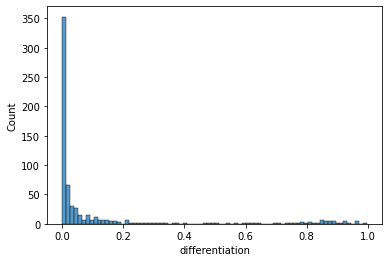

In [29]:
differentiation_observed.plot()

In [30]:
adata_oi.obs["differentiation"] = differentiation_observed.mean.to_pandas()

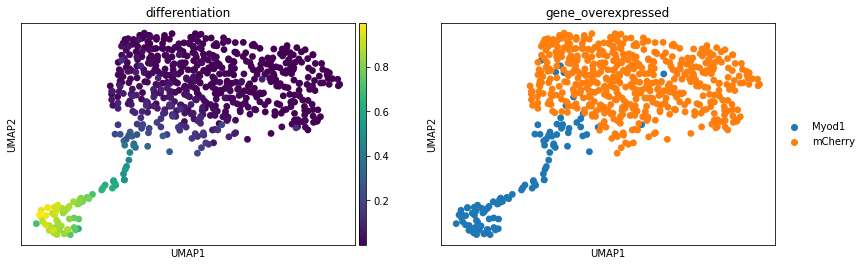

In [31]:
sc.pl.umap(adata_oi, color=["differentiation", "gene_overexpressed"])

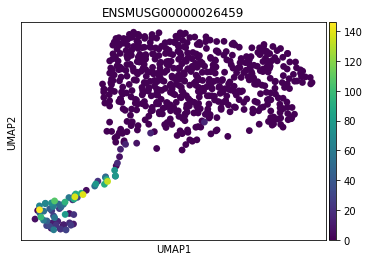

In [32]:
sc.pl.umap(
    adata_oi, color=adata.var.reset_index().set_index("symbol").loc[["Myog"]].gene
)

Let's investigate which genes are driven by differentiation:

In [33]:
differentiation_causal = la.posterior.scalar.ScalarVectorCausal(
    differentiation,
    transcriptome,
    observed=differentiation_observed,
    interpretable=transcriptome.p.mu.expression,
)
differentiation_causal.sample(10)
differentiation_causal.sample_empirical()
differentiation_causal.sample_random()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

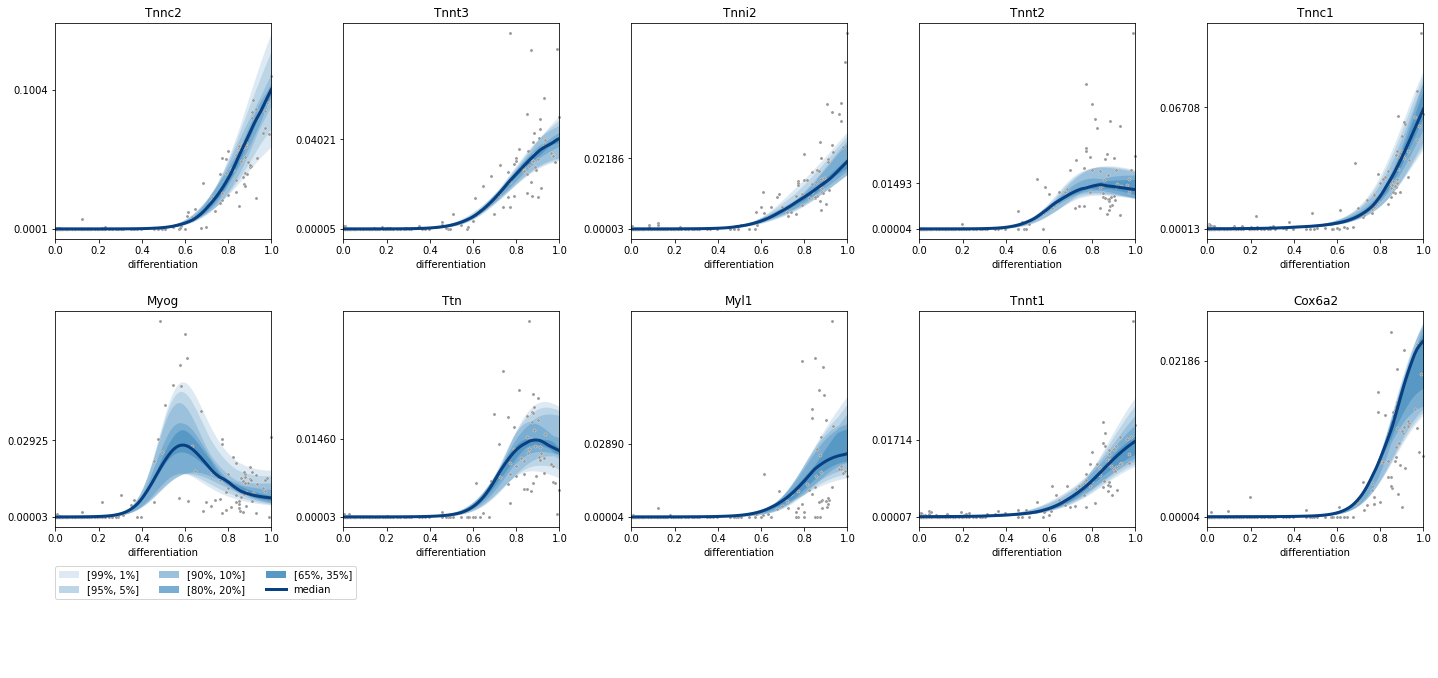

In [34]:
differentiation_causal.plot_features()

## Differentiation: increasing scalability and robustness through amortization

Because the model has to infer both cell- and gene-specific latent variables at the same time, finding a robust solution for this model be tricky. One reason for this is that that during optimization, both groups of latent variables have to follow eachother, and they can easily get stuck together in suboptimal solutions. Indeed, if you would run the above model a couple of times, you might notice that sometimes the inferred differentiation values are completely different from the "expected" situation.

One main way to make inference of a latent space more robust is to not directly infer the latent variables for each cell individually, but instead train a _amortization function_ that provides this latent space for us. This function will typically use our observation, in this case the transcriptome's count matrix, and predict the components of the variational distribution, i.e. $\mu$ and $\sigma$. We of course still have to train some parameters, namely the parameters of this amortization function, but this makes training much easier as information is shared between all cells.

The main challenge with amortization is that we need to choose a function that is extremely flexible, as it needs to combine information coming from all genes into a probably highly non-linear model. We therefore typically choose a neural network. The number of layers of this function depends on the complexity of the data. More specifically, how all features in the observation are related. A transcriptomics count matrix has fairly simple "co-expression" structure and therefore typically on requires two layers. The pixels and channels in imaging data on the other hand have a more intracate and hierarchical structure that is best captured by many layers (i.e. deep learning).

:::{note}

Don't we lose interpretability if we use this neural network?

It's certainly true that a neural network, even of a small size, can be very difficult to interpret. At best, we may be able to rank some genes according to their importance in the model. However, in our case we don't really care about this interpretability, because amortization is just a trick to make inference easier. It's important to understand that the actual interpretability always lies downstream from the variational distribution, in how the cellular latent space is related to the transcriptome. The amortization function just helps us to estimate the variational distribution, but doesn't help us with explaining the transcriptome. For a variational distribution, we therefore only want accuracy and ease of inference, which neural networks can provide, but not interpretability. In fact, in an ideal world, the optimal solution for a model with and without amortization would be the same.

:::

In [35]:
transcriptome = lac.transcriptome.TranscriptomeObservation.from_adata(adata_oi)

In [36]:
differentiation = la.Latent(
    differentiation_p, definition=[transcriptome["cell"]], label="differentiation"
)

In [37]:
encoder = la.amortization.Encoder(
    la.Fixed(transcriptome.loader, definition=transcriptome),
    differentiation,
    pretrain=False,
    lr=1e-3,
)

In [38]:
differentiation.plot()

In [39]:
foldchange = transcriptome.find("foldchange")

In [40]:
foldchange.differentiation = la.links.scalar.Spline(
    differentiation, definition=foldchange.value_definition
)

In [41]:
batch = la.variables.discrete.DiscreteFixed(adata_oi.obs["batch"])
foldchange.batch = la.links.vector.Matmul(batch, definition=foldchange.value_definition)

In [42]:
foldchange.plot()

In [43]:
with transcriptome.switch("cuda"):
    inference = la.infer.svi.SVI(
        transcriptome, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=1e-3)
    )
    trainer = la.infer.trainer.Trainer(inference)
    trace = trainer.train(10000)
    trace.plot()

    inference = la.infer.svi.SVI(
        transcriptome, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=1e-2)
    )
    trainer = la.infer.trainer.Trainer(inference)
    trace = trainer.train(10000)
    trace.plot()

  0%|                                                                                                         …

  0%|                                                                                                         …

In [44]:
differentiation_observed = la.posterior.scalar.ScalarObserved(differentiation)
differentiation_observed.sample(10)

  0%|          | 0/10 [00:00<?, ?it/s]

In [45]:
adata_oi.obs["differentiation"] = differentiation_observed.mean.to_pandas()

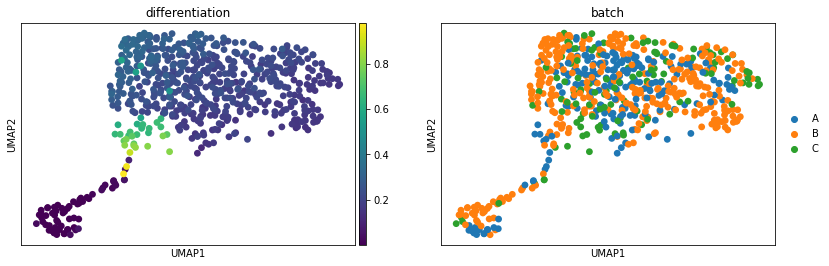

In [46]:
sc.pl.umap(adata_oi, color=["differentiation", "batch"])

In [47]:
differentiation_causal = la.posterior.scalar.ScalarVectorCausal(
    differentiation,
    transcriptome,
    observed=differentiation_observed,
    interpretable=transcriptome.p.mu.expression,
)
differentiation_causal.sample(30)
differentiation_causal.sample_empirical()
differentiation_causal.sample_random()

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

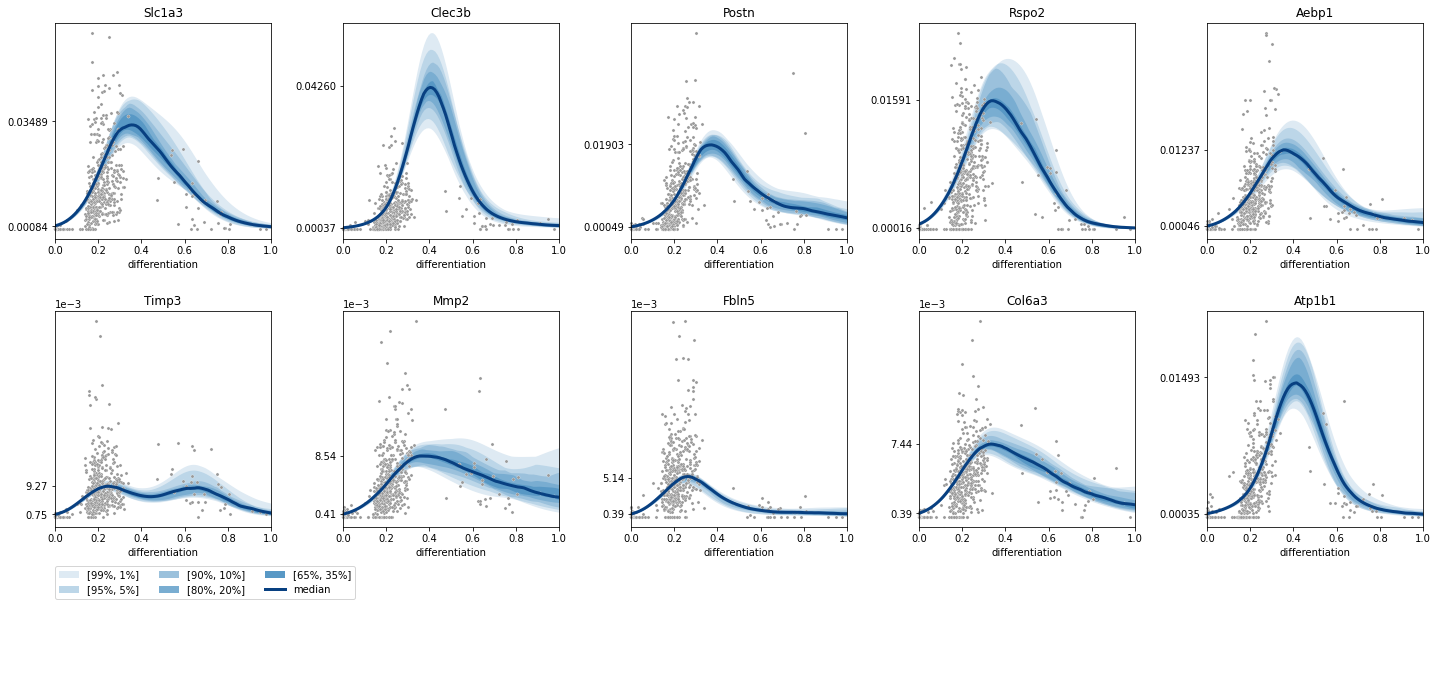

In [48]:
differentiation_causal.plot_features()

Apart from a more robust training, amortization also has a couple of additional advantages:
- Scalability, because we no longer train the variational distribution's parameters for each individual cell, which can easily go into hundreds of thousands to millions. Instead, we only infer a few dozen to a few hundred hundred parameters of the neural network.
- We get a function that can predict the latent space even on unseen cells "for free". Note however, that this does not necessarily mean that our function is generalizable, as this may depend on the assumptions, hyperparameters and structure of the neural network.

## Cell cycle: Including quite some prior knowledge

![](https://cdn.zmescience.com/wp-content/uploads/2018/10/giraffe-661648_960_720.jpg)